In [18]:
%load_ext autoreload
%autoreload 2

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules


from openbabel import pybel
from rdkit.Chem import GetPeriodicTable
import enum
import os

IPythonConsole.ipython_3d = True

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


process

Goal generate descriptor sets for a list of molecules 

Process for each molecule:
    1. generate initial geometry
        --can be done using openbabel, rdkit, maybe other way as well (ML-type way)
        --can be done for multiple molecules at on
        
    
    - run gaussian calculations
        -- create gaussian input and options
    - postprocess gaussian output
    - collect descriptors, add chem-informatics descriptors, etc.

In [43]:
class config:
    """configuration constants"""
    
    # framework config block
    data_dir = "C:/Users/AndrzejZuranski/tmp"
    db = "mysql://" # tbd
    
    # Gaussian config block
    theory = "B3LYP"
    light_set = "6-31G*"
    generic_set = "genecp"
    heavy_set = "LANL2DZ"
    max_light_atomic_number = 36
    atoms_per_processor = 6
    max_processors = 20
    ram_per_processor = 2


class input_types(enum.Enum):
    """enumeration of input types"""
    
    smiles = "smi"
    chemdraw = "cdx"
    
    
class gaussian_workflows(enum.Enum):
    """enumeration of gaussian workflows"""
    
    equilibrium = {
        "opt": lambda basis_set: f"opt=CalcFc {config.theory}/{basis_set} scf=xqc",
        "freq": lambda basis_set: f"freq {config.theory}/{basis_set} volume NMR pop=NPA density=current Geom=AllCheck Guess=Read",
        "td": lambda basis_set: f"TD(NStates=10, Root=1) {config.theory}/{basis_set} volume pop=NPA density=current Geom=AllCheck Guess=Read",
    }
    transition_state = {
        "opt": lambda basis_set: f"opt=(calcfc,ts,noeigentest) scf=xqc {config.theory}/{basis_set}",
        "freq": lambda basis_set: f"freq {config.theory}/{basis_set} volume NMR pop=NPA density=current Geom=AllCheck Guess=Read" 
    }
    

In [44]:
class gaussian_file_generator():
    """generator of gaussian input files"""
    
    def __init__(self, has_heavy, workflow, directory):
        """configure workflow and basis set to be used"""
        
        self.has_heavy = has_heavy
        self.workflow = workflow
        self.directory = directory
        
        if self.has_heavy:
            self.basis_set = config.generic_set
        else:
            self.basis_set = config.light_set

           
    def generate_file(self, name, resource_block, coords_block, 
                      light_elements, heavy_elements, charge, multiplicity):
                       
        if self.has_heavy:
            heavy_block = ""
            heavy_block += "\n" + " ".join(light_elements + ["0"]) + "\n"
            heavy_block += f"{config.light_set}\n****"
            heavy_block += "\n" + " ".join(heavy_elements + ["0"]) + "\n"
            heavy_block += f"{config.heavy_set}\n****\n"
            heavy_block += "\n" + " ".join(heavy_elements + ["0"]) + "\n"
            heavy_block += f"{config.heavy_set}\n"
            
        output = ""
        output += resource_block
        output += f"%Chk={name}_1.chk\n"
        
        # geoemtry optimization
        output += f"# {self.workflow.value['opt'](self.basis_set)}\n\n"
        output += f"{name}\n\n"
        output += f"{charge} {multiplicity}\n"
        output += coords_block
        
        # add heavy block
        if self.has_heavy:
            output += heavy_block
        
        # frequency calculation
        output += "\n\n\n--Link--1\n"
        output += resource_block
        output += f"%Oldchk={name}_1.chk\n"
        output += f"%Chk={name}_2.chk\n"
        output += f"# {self.workflow.value['freq'](self.basis_set)}\n"
        
        if self.has_heavy:
            output += heavy_block
        
        # time_dependent calculation (only for equilibrium workflow)
        if 'td' in self.workflow.value:
            output += "\n\n\n--Link--1\n"
            output += resource_block
            output += f"%Oldchk={name}_2.chk\n"
            output += f"%Chk={name}_3.chk\n"
            output += f"{self.workflow.value['td'](self.basis_set)}\n"
            
            if self.has_heavy:
                output += heavy_block
        
        with open(f"{self.directory}/{name}.gjf", "w") as file:
            file.write(output)

In [45]:
class qmol(object):
    """Class that holds a single molecule information"""
    
    pt = GetPeriodicTable()
    
    def __init__(self, input_string, input_type=input_types.smiles, n_conformers=None):
        """initialize the molecule"""
        
        self.name = input_string
        self.directory = f"{config.data_dir}/{self.name}"
        self.mol = pybel.readstring(input_type.value, input_string)
        self.mol.addh() 
        self.mol.make3D() # make use of pybel api (harder to do with OBBuilder directly)
        self.mol.localopt()
                      
        if n_conformers is not None:
            self.__generate_conformers(n_conformers)
 
        
    def __generate_conformers(self, n_conformers):
        """generate conformations"""
        
        confSearch = pybel.ob.OBConformerSearch()
        confSearch.Setup(self.mol.OBMol, n_conformers)
        confSearch.Search()
        confSearch.GetConformers(self.mol.OBMol)
    
    def __group_light_heavy_elements(self):
        """group elements into light and heavy for this molecule"""
        
        atomic_nums = set(atom.atomicnum for atom in self.mol.atoms)
        heavy_elements = [self.pt.GetElementSymbol(n) for n in atomic_nums if n > config.max_light_atomic_number]
        light_elements = [self.pt.GetElementSymbol(n) for n in atomic_nums if n <= config.max_light_atomic_number]
        return heavy_elements, light_elements
    
    def create_gaussian_files(self, workflow=gaussian_workflows.equilibrium):
        """write gaussian files for each conformation with defined options"""

        # make directory for files
        os.makedirs(self.directory, exist_ok=True)
        
        # group elements by heavy and light
        heavy_elements, light_elements = self.__group_light_heavy_elements()
        has_heavy = len(heavy_elements) > 0
        
        # configure gaussian output writer
        gfg = gaussian_file_generator(has_heavy, workflow, self.directory)
        
        # resources configuration
        n_processors = max(20, len(self.mol.atoms) // config.atoms_per_processor)
        RAM = n_processors * config.ram_per_processor
        resource_block = f"%nprocshared={n_processors}\n%Mem={RAM}GB\n"

        conv = pybel.ob.OBConversion()
        conv.SetOutFormat("xyz")
        
        for conf_id in range(self.mol.OBMol.NumConformers()):
            # set conformer
            self.mol.OBMol.SetConformer(conf_id)
            conf_name = f"{self.name}_conf_{conf_id}"
            
            # coordinates block, use babel to convert and skip first 2 lines
            coords_string = conv.WriteString(self.mol.OBMol)
            coords_block = "\n".join(coords_string.split("\n")[2:])
            
            gfg.generate_file(conf_name,
                              resource_block,
                              coords_block,
                              light_elements,
                              heavy_elements,
                              self.mol.charge,
                              self.mol.spin)
            
            
    def cleanup_gaussian_files(self):
        """cleanup gaussian input/output files"""
        for file in os.listdir(self.directory):
            os.remove(os.path.join(self.directory, file))
        os.rmdir(self.directory)
        

In [46]:
m=qmol("Cc1ccccc1P(c2ccccc2C)c3ccccc3C", input_types.smiles, n_conformers=5)

In [47]:
m.create_gaussian_files()

In [25]:
m.cleanup_gaussian_files()

In [26]:
m=qmol("Cc1ccccc1P(c2ccccc2C)c3ccccc3C", input_types.smiles, n_conformers=3)
print (m.mol.OBMol.NumConformers())

3


In [34]:
def get_molecule_rdkit(smiles) -> Chem.Mol:
    """create rdkit molecule and optimize it's geometry using MMFF"""
    
    mol = Chem.MolFromSmiles(smiles)
    mol = AllChem.AddHs(mol)
    
    AllChem.EmbedMolecule(mol)
    status = AllChem.MMFFOptimizeMolecule(mol)
    
    return mol, status

In [35]:
def get_conformers_rdkit(smiles, n_conformers=10) -> Chem.Mol:
    """create rdkit molecule conformers and optimize their geometry using MMFF"""
    
    mol, status = get_molecule_rdkit(smiles)
    AllChem.EmbedMultipleConfs(mol, numConfs=n_conformers)
    status_and_energies = AllChem.MMFFOptimizeMoleculeConfs(mol)
    
    return mol, status_and_energies

In [36]:
def get_molecule_openbabel(smiles) -> pybel.ob.OBMol:
    
    mol = pybel.readstring("smi", smi)
    mol.addh()
    mol.make3D()
    mol.localopt()
    
    return mol.OBMol

In [37]:
def get_conformers_openbabel(smiles, n_conformers=10):
    
    mol = get_molecule_openbabel(smiles)
    
    conf_search = pybel.ob.OBConformerSearch()
    conf_search.Setup(mol, n_conformers)
    conf_search.GetConformers(mol)
    
    return mol

In [38]:
def save_conformers_as_gjf(mol, path="data") -> None:
    """generates gjf files for each conformer of a molecule
    this is not directly supported by rdkit"""
        
    for conf in mol.GetConformers():
        mol_block = Chem.MolToMolBlock(mol, conf.GetId())
        pybel_mol = pybel.readstring("mol", mol_block)
        pybel_mol.title = f"{conf.GetId()}"
        pybel_mol.write(format="gjf", filename=f"{path}/{pybel_mol.title}.gjf", overwrite=True)

In [42]:

smi = 'C1CCC(CC1)[PH+](C2CCCCC2)C3CCCCC3'
m, c=get_conformers_rdkit(smi, n_conformers=3)
save_conformers_as_gjf(m, path="C:\\Users\\AndrzejZuranski\\tmp")

In [59]:
c

[(0, 19.702240117495144), (1, 29.975368611158803), (1, 21.213076270304203)]

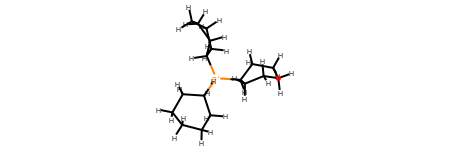

In [46]:
m

In [6]:
smiles_sheet = pd.read_csv("data/smiles_examples.csv", header=None)

In [7]:
smiles_sheet

,0
0,C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...
1,[B-](F)(F)(F)F.C1CCC(CC1)[PH+](C2CCCCC2)C3CCCCC3
2,Cc1ccccc1P(c2ccccc2C)c3ccccc3C
3,COc1ccccc1P(c2ccccc2OC)c3ccccc3OC
4,CC1=CC=CC=C1C2=CC=CC=C2P(C3CCCCC3)C4CCCCC4
...,...
61,CCCCP(C12CC3CC(C1)CC(C3)C2)C45CC6CC(C4)CC(C6)C5
62,CN(C)c1ccccc1c2ccccc2P(C(C)(C)C)C(C)(C)C
63,CC(C)C1=CC(=C(C(=C1)C(C)C)C2=C(C=CC(=C2P(C3=CC...
64,O(P(Oc1ccccc1)Oc2ccccc2)c3ccccc3


In [ ]:
for smi in smiles_sheet[0].values:
    print (smi)
    m = generate_conformers(smi)

C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C3)C5=C(C=CC6=CC=CC=C65)P(C7=CC=CC=C7)C8=CC=CC=C8
[B-](F)(F)(F)F.C1CCC(CC1)[PH+](C2CCCCC2)C3CCCCC3
